# Togetherflow
**Emergent agent motion dynamics in immersive rooms**

In this notebook, we implement Togetherflow, a computational cognitive model that characterizes the motion pattern of human agents in immersive rooms.

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

from scipy import stats
from IPython.display import HTML

np.set_printoptions(suppress=True)

In [54]:
import tensorflow as tf
import bayesflow as bf
from bayesflow.simulation import Prior, Simulator, GenerativeModel

## Generative Model Definition

The movement of any agent $a = 1, ..., A$ is both related to: 1) its interaction with surrounding neighbors $i = 1, ..., I$, which we call *internal influence*, and 2) their motivation to the surrounding spatial objects $j = 1, ..., J$, which we call *external influence*. These influences are modulated by a stationary weight, $w_a$:

\begin{equation}
    \theta_{a, t} = w_a \theta_{a|j, t} + (1 - w_a) \theta_{a|i, t}.
\end{equation}

### Meta-Variables

First, we define some meta-variables, such as the number of agents to simulate, the number of spatial beacons present in the environment, etc.

In [55]:
num_agents = 12
num_beacons = 2
room_size = (8., 10.)
world_size = 25.

### Agent Initialization

First, we initialize the agents with a randomized position and orientation, both uniformly distributed.

In [7]:
def initialize_agents(
        num_agents: int = 100, 
        boundary_size: float = 100.0
) -> tuple[np.ndarray, np.ndarray]:
    """
    Generate random positions and orientations for agents.

    Parameters
    ----------
    num_agents : int, optional
        Number of agents to generate (default is 100).
    boundary_size : float, optional
        The size of the boundary within which positions are generated (default is 100.0).

    Returns
    -------
    tuple of np.ndarray
        A tuple containing the positions (np.ndarray) and orientations (np.ndarray) of the agents.
    """
    
    # Generate random positions within the boundary size centered at 0
    positions = np.random.uniform(-boundary_size * 0.5, boundary_size * 0.5, (num_agents, 2))
    
    # Generate random orientations (angles in radians between 0 and 2*pi)
    orientations = np.random.uniform(0, 2 * np.pi, num_agents)
    
    return positions, orientations

In [56]:
agent_positions, agent_directions = initialize_agents(boundary_size=room_size)
np.cos(agent_directions)

array([[ 0.5264093 ],
       [ 0.5004875 ],
       [ 0.8032966 ],
       [-0.8912787 ],
       [ 0.8759352 ],
       [-0.89904433],
       [ 0.4725748 ],
       [-0.9750324 ],
       [-0.8698092 ],
       [-0.9135189 ],
       [ 0.6402145 ],
       [ 0.89513695]], dtype=float32)

Text(0, 0.5, 'y')

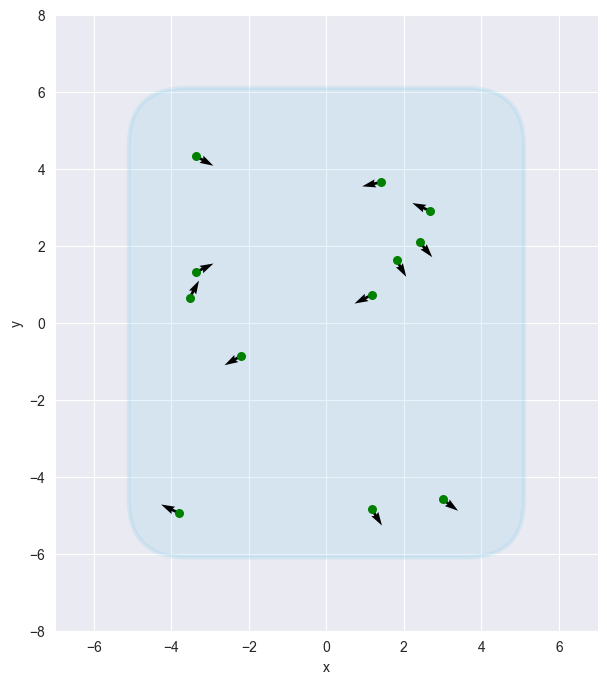

In [57]:
from matplotlib.patches import FancyBboxPatch

fig, ax = plt.subplots(1, 1, figsize=(7, 8))

# Create a rounded rectangle with translucent face color
rounded_rect = FancyBboxPatch(
    (-5, -6),       # Lower left corner
    width=10.,        # Width
    height=12.,       # Height
    boxstyle="round,pad=0.1,rounding_size=1.5",  # Rounded box
    edgecolor=(0.53, 0.81, 0.92, 1),
    facecolor=(0.53, 0.81, 0.92, 0.2),
    linewidth=3,
    alpha=0.2         # Set opacity level (0 is fully transparent, 1 is fully opaque)
)

ax.add_patch(rounded_rect)
ax.quiver(
    agent_positions[:, 0], agent_positions[:, 1], 
    np.cos(agent_directions), np.sin(agent_directions), 
    angles='xy', scale_units="xy", 
    scale=2, width=0.005
)
ax.scatter(agent_positions[:, 0], agent_positions[:, 1], c='g', s=30)
ax.set_xlim([-7, 7])
ax.set_ylim([-8, 8])
ax.set_xlabel('x')
ax.set_ylabel('y')

### Beacon initialization

To intrinsically motivate the agents, we need a set of virtual beacons that are populated within the environment. The beacons have a freer representation with only positions needed.

In [60]:
def initialize_beacons(
        num_beacons = 10,
        room_sensing_range = 50.
):
    
    """
    Initialize beacons following a uniform distribution scaled to the room's sensing boundary
    
    Parameters
    ----------
    num_beacons : int, default: 10
        Number of beacons to initialize.
    environment_size : float, default: 50.0
        Size of the environment for the generation of beacons.
    
    Returns
    -------
    beacons      : np.ndarray of shape (num_beacons, 2)
        Initial positions of the beacons. 
    """
    
    beacons = np.random.uniform(-room_sensing_range * 0.5, room_sensing_range * 0.5, size=(num_beacons, 2))
    return beacons

In [61]:
beacon_positions = initialize_beacons(num_beacons=6, room_sensing_range=world_size)
beacon_positions

array([[  9.37884947,   1.00093544],
       [ -8.54157618,  -2.25172881],
       [  5.6142952 ,  10.47163023],
       [  8.71585978, -11.51664728],
       [  7.51107906,  -6.605834  ],
       [  9.35596775,   8.24765411]])

Text(0, 0.5, 'y')

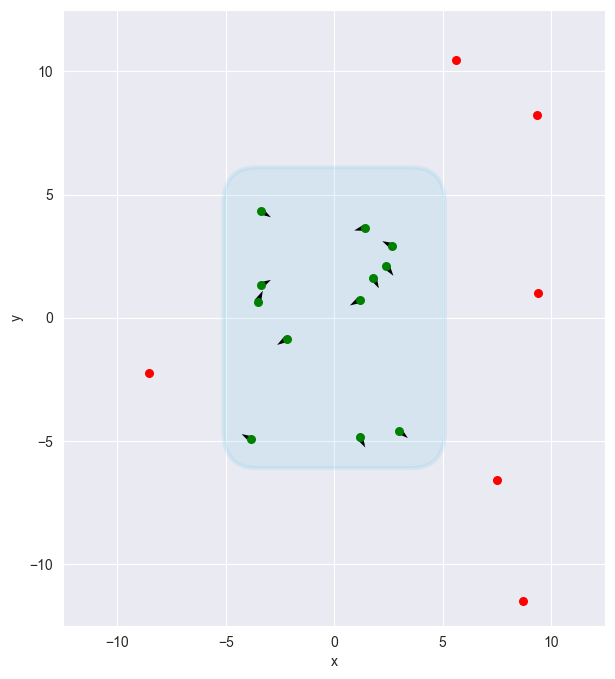

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(7, 8))

# Create a rounded rectangle with translucent face color
rounded_rect = FancyBboxPatch(
    (-5, -6),       # Lower left corner
    width=10.,        # Width
    height=12.,       # Height
    boxstyle="round,pad=0.1,rounding_size=1.5",  # Rounded box
    edgecolor=(0.53, 0.81, 0.92, 1),
    facecolor=(0.53, 0.81, 0.92, 0.2),
    linewidth=3,
    alpha=0.2         # Set opacity level (0 is fully transparent, 1 is fully opaque)
)

ax.add_patch(rounded_rect)
ax.quiver(
    agent_positions[:, 0], agent_positions[:, 1], 
    np.cos(agent_directions), np.sin(agent_directions), 
    angles='xy', scale_units="xy", 
    scale=2, width=0.005
)
ax.scatter(agent_positions[:, 0], agent_positions[:, 1], c='g', s=30)
ax.scatter(beacon_positions[:, 0], beacon_positions[:, 1], c='r', s=30)
ax.set_xlim([-0.5 * world_size, 0.5 * world_size])
ax.set_ylim([-0.5 * world_size, 0.5 * world_size])
ax.set_xlabel('x')
ax.set_ylabel('y')

## Internal Influence

We want to compute the influence of agent movement direction within a single time step. For this, we specify our internal influence as a 2D drift diffusion model, where the agents are approach a spatial beacon within the room's boundary by reorienting its locomotive direction.

\begin{equation}
    \theta_{a|j, t} = \theta_{a|j, t-1} + \omega_a \mathrm{d}t + \mathrm{d}\phi_t,
\end{equation}

\begin{align}
    \mathrm{d}\mathbf{x}_{a|j, t} 
    &= v_{a|j}\mathrm{d}t \frac{\mathbf{x}_{a|j}}{||\mathbf{x}_{a|j}||} + \sigma_{a|j} \mathrm{d}\mathrm{W}_t \\
    &= v_{a}\mathrm{d}t     
    \begin{bmatrix}
        \cos \theta_{a|j, t} \\
        \sin \theta_{a|j, t}
    \end{bmatrix} + \sigma_{a|j} \mathrm{d}\mathrm{W}_t,% \sqrt{\mathrm{d}t} Z_t.
\end{align}

In [23]:
def internal_influence(
        beacon_position,
        agent_position,
        agent_rotation,
        movement_speed = 1.,
        rotation_speed = 0.1,
        noise_level = 0.1,
        dt = 0.1      
):
    """
    Internally influence the agent's position and direction for a single time step
    given the target position and rotation speeds.
    
    Parameters
    ----------
    target_position : np.ndarray of shape (2,)
        Position of the agent's target.
    agent_position : np.ndarray of shape (2,)
        Position of the agent.
    agent_rotation : float
        Orientation of the agent.
    movement_speed : float
        Speed of the agent's movement.
    rotation_speed : float
        Speed of the agent's rotation.
    noise_level : float
        Rotational noise level of the agent.
    dt : float, default: 1.
        Time step of the simulation.
    
    Returns
    -------
    new_position : np.ndarray of shape (2,)
        Updated position of the agent.
    new_rotation : float
        Updated orientation of the agent.
    """
    
    # Declare new agent positions and rotation
    new_position = agent_position
    new_rotation = agent_rotation
    
    # Compute relative orientation between the agent and the look-at target
    beacon_orientation = np.arctan2(
        beacon_position[1] - agent_position[1], 
        beacon_position[0] - agent_position[0]
    )
    
    # Calculate drift rate and noise
    drift = rotation_speed * (beacon_position - agent_rotation) * dt
    noise = np.random.vonmises(mu=0, kappa=1 / (noise_level * noise_level))
    
    # Update and normalize agent rotation
    new_rotation += drift + noise
    new_rotation = (new_rotation + np.pi) % (2 * np.pi) - np.pi
    
    # Update agent position
    new_position[0] += movement_speed * np.cos(new_rotation.item()) * dt
    new_position[1] += movement_speed * np.sin(new_rotation.item()) * dt
    
    return new_position, new_rotation

In [33]:
def simulate_internal_influence(
        num_agents: int = 1,
        num_beacons: int = 1,
        num_timesteps: int = 1001
):
    """
    Simulate the influence of the agents' internal influence only.
    
    Parameters
    ----------
    num_agents      : int, default: 12
        Number of agents to simulate.
    num_beacons      : int, default: 10
        Number of beacons to simulate.
    num_timesteps     : int, default: 1001
        Number of timesteps to simulate. 
    """
    
    agent_positions = np.zeros((num_timesteps, num_agents, 2))
    agent_rotations = np.zeros((num_timesteps, num_agents, 1))
    
    beacon_positions = initialize_beacons(num_beacons=num_beacons)
    
    agent_positions[0], agent_rotations[0] = initialize_agents(num_agents=num_agents)
    
    for i in range(1, num_timesteps):
        old_position = agent_positions[i-1].copy() 
        old_rotation = agent_rotations[i-1].copy()
        for j in range(num_agents):
            beacon_orientation = np.arctan2(
                beacon_positions[0, 1] - old_position[j, 1], 
                beacon_positions[0, 0] - old_position[j, 0]
            )
            
            new_position, new_rotation = internal_influence(
                beacon_positions[0], # Set only one beacon to test, for now.
                old_position[j], 
                old_rotation[j]
            )
            
            if np.abs(new_rotation - beacon_orientation) < np.pi * 0.01:
                break
            
            agent_positions[i, j] = new_position
            agent_rotations[i, j] = new_rotation
    
    return agent_positions, agent_rotations, beacon_positions

In [51]:
agent_positions, agent_rotations, beacon_positions = simulate_internal_influence(num_timesteps=1001)
agent_positions.shape

(1001, 1, 2)

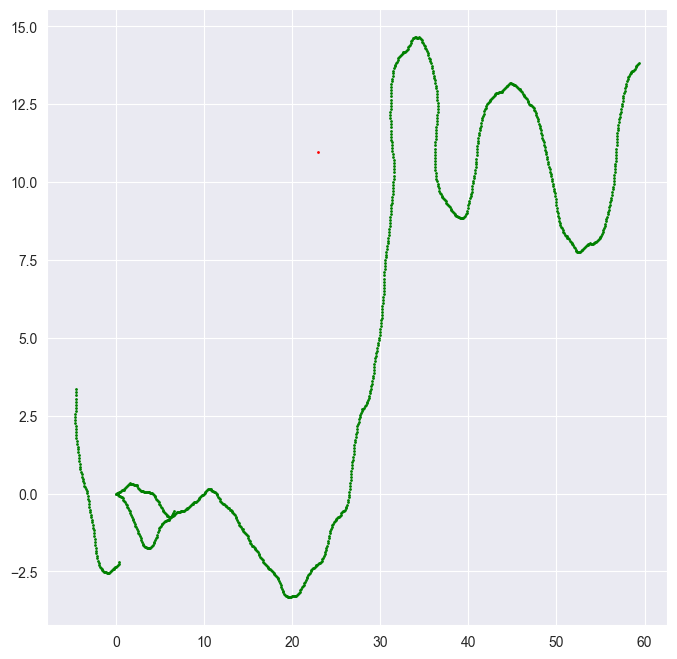

In [52]:
f, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(agent_positions[:, :, 0], agent_positions[:,:, 1], c='g', s=1)
ax.scatter(beacon_positions[:,0], beacon_positions[:,1], c='r', s=1)

Text(0, 0.5, 'Rotation (rad)')

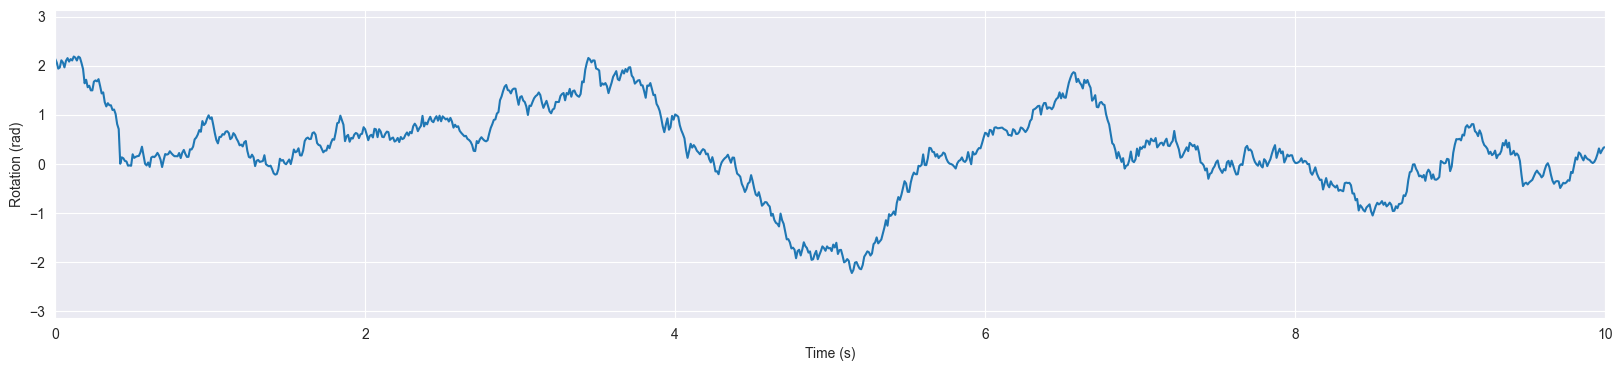

In [30]:
f, ax = plt.subplots(1, 1, figsize=(20, 4))
for i in range(1):
    ax.plot(np.linspace(0, 10, 1001), agent_rotations[:,i])
ax.set_xlim([0, 10])
ax.set_ylim([-np.pi, np.pi])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Rotation (rad)")

In [31]:
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyBboxPatch
from IPython.display import HTML

def animate(agent_positions, agent_rotations, env_size = 50.):
    
    fig, ax = plt.subplots(figsize=(4, 4))
    
    # Create a rounded rectangle with translucent face color
    rounded_rect = FancyBboxPatch(
        (-5, -6),       # Lower left corner
        width=10.,        # Width
        height=12.,       # Height
        boxstyle="round,pad=0.1,rounding_size=1.5",  # Rounded box
        edgecolor=(0.53, 0.81, 0.92, 1),
        facecolor=(0.53, 0.81, 0.92, 0.2),
        linewidth=3,
        alpha=0.2         # Set opacity level (0 is fully transparent, 1 is fully opaque)
    )

    def update(frame):
        ax.clear()
        quiver = ax.quiver(
            agent_positions[frame, :, 0], agent_positions[frame, :, 1], 
            np.cos(agent_rotations[frame]), np.sin(agent_rotations[frame])
        )
        quiver.set_offsets(agent_positions[frame])
        quiver.set_UVC(np.cos(agent_rotations[frame]), np.sin(agent_rotations[frame]))
        ax.set_xlim(-env_size, env_size)
        ax.set_ylim(-env_size, env_size)
        return quiver,

    a = FuncAnimation(fig, update, frames=len(agent_positions), blit=True, repeat=False)
    plt.title("Simulated Internal Influence")
    plt.xlabel("X")
    plt.ylabel("Y")
    
    return a

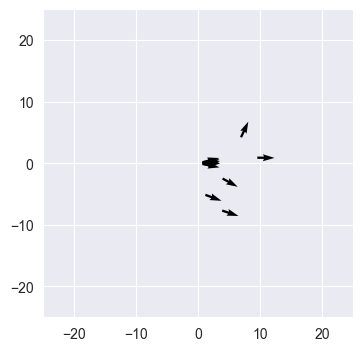

In [32]:
agent_positions, agent_rotations, beacon_positions = simulate_internal_influence(num_timesteps=100)
a = animate(agent_positions, agent_rotations, env_size=25)
HTML(a.to_jshtml())

### External Influence

Its influence by a collective group of agents is modeled as a self-propelling particle system:

\begin{align}
    \theta_{a|i, t} &= \langle \theta_{i, t}\rangle_{|\mathbf{x}_a - \mathbf{x}_i| < r_a, i \in I} + \eta_{a,t-1}, \\
    \mathrm{d} \mathbf{x}_{a|i,t} &= v_{a,t} \mathrm{d}t
    \begin{bmatrix}
        \cos \theta_{a|i, t} \\
        \sin \theta_{a|i, t}
    \end{bmatrix},
\end{align}

In [3]:
def external_influence(
        agent_positions,
        agent_rotations,
        neighbor_positions, 
        neighbor_rotations,
        dt = 0.1 
):
    """
    Externally influence the agent's position and direction for a single time step
    given the neighboring agent's position and orientation.
    
    Parameters
    ----------
    agent_position : np.ndarray of shape (2,)
        Position of the agent.
    agent_rotation : float
        Orientation of the agent.
    neighbor_positions : np.ndarray of shape (2,)
        Positions of the neighboring agent.
    neighbor_rotation : float
        Orientations of the neighboring agent.
    dt : float, default: 1.
        Time step of the simulation.
    
    Returns
    -------
    new_position : np.ndarray of shape (2,)
        Updated position of the agent.
    new_rotation : float
        Updated orientation of the agent.
    """
    assert len(neighbor_positions) == len(neighbor_rotations), \
        f"Number of neighboring agents' positions ({len(neighbor_positions)}) " +\ 
        f"does not match number of their rotations ({len(neighbor_rotations)})."
    
    new_position = agent_positions
    new_rotation = agent_rotations
    
    # Compute average positions and rotations for neighbors
    average_neighbor_position = np.mean(neighbor_positions)
    # average_neighbor_rotation = np.mean(neighbor_rotations)
    
    # Update position and rotation
    new_rotation += average_neighbor_position 
    
    new_position[0] += np.cos(new_rotation.item()) * dt
    new_position[1] += np.sin(new_rotation.item()) * dt
    
    return new_position, new_rotation

<>:32: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:32: SyntaxWarning: assertion is always true, perhaps remove parentheses?
C:\Users\Gerald Wong\AppData\Local\Temp\ipykernel_13400\3185535147.py:32: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (


In [1]:
def simulate_external_influence(
    theta,
    num_agents=12,
    num_timesteps=100,
    boundary_size=10.0,
):
    """
    Simulate the movement trajectory of the agent, 
    as governed by the Vicsek model.
    
    Parameters
    ----------
    theta : np.ndarray of shape (2, )
        Sampled priors for the model, including the 
        base sensing radius (r) and walking speed (v)
        of the agents.
    num_agents     : int, default: 12
        Number of agents to simulate.
    num_timesteps   : int, default: 100
        Number of timesteps to simulate.
    boundary_size   : float, default: 10.0
        Size of the simulation boundary (in meters).
    
    Returns
    -------
    A concatenated NumPy array of combined trajectory 
    and direction of the agents as timeseries.
    """
    
    
    # Unpack priors
    r, v = theta[0], theta[1]
    
    # Scale radius with half of boundary size (for realism)
    sensing_radius = r * boundary_size * 0.5

    # Store trajectories and headings
    agent_positions = np.zeros((num_timesteps, num_agents, 2))
    agent_rotations = np.zeros((num_timesteps, num_agents, 1))

    # Initialize positions and directions for each agent
    agent_positions[0], agent_rotations[0] = initialize_agents(num_agents, boundary_size)

    # Loop over each timestep
    for t in range(1, num_timesteps):
        # Get previous positions and rotations
        old_positions = agent_positions[t-1].copy()
        old_rotations = agent_rotations[t-1].copy()
        
        # For each timestep, initialize directions for the agents
        new_rotations = np.zeros(num_agents)
        
        # For each agent, collect neighbors within its sensing range
        for i in range(num_agents):
            neighbor_rotations = []
            # If there are any neighbors, average over their directions 
            # and assign it as the new direction. 
            for j in range(num_agents):
                if i != j and np.linalg.norm(agent_positions[t-1, i] - agent_positions[j]) < sensing_radius:
                    neighbor_rotations.append(agent_rotations[j])
            if neighbor_rotations != []:
                average_neighbor_rotation = np.mean(np.array(neighbor_rotations))
                new_rotations[i] = average_neighbor_rotation + np.random.uniform(-0.01, 0.01)
            else:
                new_rotations[i] = agent_rotations[i]

        agent_rotations = np.copy(new_rotations)
        
        # Update position upon new direction
        agent_positions[:,0] += v * np.cos(agent_rotations)
        agent_positions[:,1] += v * np.sin(agent_rotations)
        
        # Assumes periodic boundary condition (for now)
        agent_positions = np.mod(np.copy(agent_positions), boundary_size)

        # Add timestamps to trajectories and headings
        agent_positions[t + 1] = np.copy(agent_positions)
        agent_rotations[t + 1] = np.copy(agent_rotations[:, np.newaxis])

    return np.concatenate((agent_positions, agent_rotations), axis=-1)
    

In [63]:
def simulator_fun(
    positions: np.ndarray, 
    orientations: np.ndarray, 
    velocity: float = 1.0, 
    external_influence: np.ndarray = np.array([1.0, 0.5]), 
    internal_influence: np.ndarray = np.array([-0.5, 1.0]), 
    dt: float = 0.1, 
    influence_weight: float = 0.7
) -> tuple[np.ndarray, np.ndarray]:
    """
    Update the positions and orientations of agents based on velocity and influence vectors.

    Parameters
    ----------
    positions : np.ndarray
        Current positions of the agents.
    orientations : np.ndarray
        Current orientations of the agents.
    velocity : float, optional
        The speed at which agents move (default is 1.0).
    external_influence : np.ndarray, optional
        The first influence vector affecting agent orientation (default is np.array([1.0, 0.5])).
    internal_influence : np.ndarray, optional
        The second influence vector affecting agent orientation (default is np.array([-0.5, 1.0])).
    dt : float, optional
        The time step for updating positions and orientations (default is 0.1).
    influence_weight : float, optional
        The weight of influence_vector1 in determining new orientations (default is 0.7).

    Returns
    -------
    tuple of np.ndarray
        Updated positions (np.ndarray) and orientations (np.ndarray) of the agents.
    """
    # Update positions based on current orientations
    positions[:, 0] += velocity * np.cos(orientations) * dt
    positions[:, 1] += velocity * np.sin(orientations) * dt
    
    # Combine influences to update orientations with different weights
    orientations += (influence_weight * external_influence + (1 - influence_weight) * internal_influence) * dt
    
    # Ensure orientations are within the range [0, 2*pi]
    orientations = np.mod(orientations, 2 * np.pi)
    
    return positions, orientations

# Priors

In [49]:
def prior_fun():
    pass

# Generative Model

In [52]:
prior = bf.simulation.Prior(prior_fun=prior_fun)

simulator = bf.simulation.Simulator(simulator_fun=simulator_fun)

model = bf.simulation.GenerativeModel(
    prior=prior,
    simulator=simulator,
    simulator_is_batched=False
)

TypeError: simulator_fun() takes 0 positional arguments but 1 was given

# Configurator

In [46]:
def configurator(input_dict: dict = None, transpose: bool = True):
    
    output_dict = {}
    output_dict['parameters'] = input_dict['prior_draws'].astype(np.float32)
    x = input_dict['sim_data'] / 10. 
    if transpose:
        x = np.transpose(x, (0, 2, 1, 3))
    output_dict['summary_conditions'] = x.astype(np.float32)
    return output_dict

# Neural Approximator

In [47]:
# This one generalizes over different numbers of agents
summary_net = bf.summary_networks.HierarchicalNetwork([
    tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(units=128)),
    bf.networks.SetTransformer(num_inducing_points=None, input_dim=128, summary_dim=64)
])

inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=2, 
    num_coupling_layers=5,
    coupling_design="affine",
    coupling_settings={
        'kernel_regularizer': None,
        'dropout_prob': 0.0
    }
)


amortizer = bf.amortizers.AmortizedPosterior(
    summary_net=summary_net, 
    inference_net=inference_net
)


trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

NameError: name 'model' is not defined